# Multilayer Perceptron for MNIST dataset

from https://colab.research.google.com/drive/1fH4YVMarfwGZVTbS2WIXIxJCT9JOPOzM?usp=sharing#scrollTo=eC2P8WJuREv_

### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [2]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

C:\Users\denis\anaconda3\envs\Geeshot\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import copy
import random
import time

### Reproducibility

In [5]:
# Set the seed for reproducibility
SEED = 420
random.seed(SEED)  # Set the random seed for Python's built-in random module
np.random.seed(SEED)  # Set the random seed for NumPy
torch.manual_seed(SEED)  # Set the random seed for PyTorch's CPU RNG
torch.cuda.manual_seed(SEED)  # Set the random seed for PyTorch's CUDA RNG
torch.backends.cudnn.deterministic = True  # Make PyTorch's CUDA convolution functions deterministic

### Downloading dataset

In [6]:
ROOT = '.data'
train_data = datasets.MNIST(root = ROOT, train = True, download = True)

### Calculating statistics for normalization

In [7]:
# train_data is a PyTorch dataset
# train_data.data is a tensor containing pixel values of the dataset
# Compute the mean and standard deviation of pixel values in train_data
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
# / 255 scales the pixel values between 0 and 1

In [8]:
print(f'Calculated mean: {mean:.3f}')
print(f'Calculated std: {std:.3f}')

Calculated mean: 0.131
Calculated std: 0.308


### Defining transformations

In [9]:
# define transformations for the training data
train_transforms = transforms.Compose([
                        # randomly rotate the image by up to 5 degrees
                        transforms.RandomRotation(5, fill=(0,)),
                        # randomly crop a 28x28 square from the image with padding of 2 pixels
                        transforms.RandomCrop(28, padding = 2),
                        # convert the image to a PyTorch tensor
                        transforms.ToTensor(),
                        # normalize the tensor using the mean and standard deviation
                        transforms.Normalize(mean = [mean], std = [std])
                                 ])

# define transformations for the testing data
test_transforms = transforms.Compose([
                       # convert the image to a PyTorch tensor
                       transforms.ToTensor(),
                       # normalize the tensor using the mean and standard deviation
                       transforms.Normalize(mean = [mean], std = [std])
                                 ])

### Loading dataset

In [10]:
# Load the MNIST train and test datasets with the defined transforms
train_data = datasets.MNIST(root=ROOT, train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST(root=ROOT, train=False, download=True, transform=test_transforms)

In [11]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


### Visualizing data

In [12]:
def plot_images(images):

    # get the number of images
    n_images = len(images)

    # calculate the number of rows and columns needed for a square grid
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    # create a new figure
    fig = plt.figure()

    # loop through each image in the list and add it to the plot
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off')

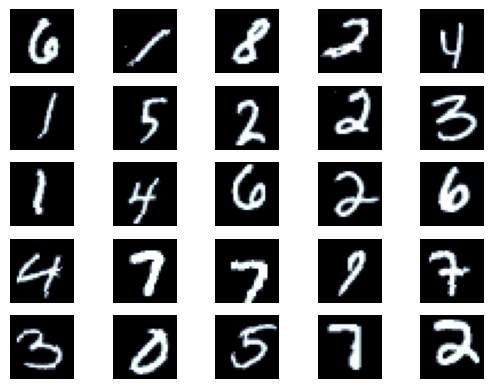

In [13]:
# Define the number of images to display
N_IMAGES = 25

# Select N_IMAGES random indices without replacement from the training data
indices = random.sample(range(len(train_data)), N_IMAGES)

# Get the images and labels corresponding to the selected indices
images = [train_data[i][0] for i in indices]

# Plot the images
plot_images(images)

### Creating validation set

In [14]:
VALID_RATIO = 0.9

# Calculate the number of training and validation examples
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

# Split the original train_data into train and valid datasets based on the calculated examples
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [15]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


### Removing tranforms from validation set

In [16]:
valid_data = copy.deepcopy(valid_data)  # deepcopy in order to not affect the train data
valid_data.dataset.transform = test_transforms  # applying same transforms as for test data

### Creating batches of the data for the SGD algorithm

In [17]:
BATCH_SIZE = 64

# Create training data iterator with batch size 64 and shuffling
train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

# Create validation data iterator with batch size 64
valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

# Create test data iterator with batch size 64
test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining MLP object

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        # MLP architecture - input, hidden 1, hidden 2, output
        self.input_fc = nn.Linear(input_dim, 250)  # hidden 1
        self.hidden_fc = nn.Linear(250, 100)  # hidden 2
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        """
        Forward pass of the MLP model.

        Args:
            x: Input tensor of shape [batch size, height, width].

        Returns:
            y_pred: Output tensor of shape [batch size, output dim].
            h_2: Hidden layer output tensor of shape [batch size, 100].
        """
        #x = [batch size, height, width]
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        # Reshape x to [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))  # h_1 = [batch size, 250]
        # Apply ReLU activation to the hidden layer 1 output

        h_2 = F.relu(self.hidden_fc(h_1))  # h_2 = [batch size, 100]
        # Apply ReLU activation to the hidden layer 2 output

        y_pred = self.output_fc(h_2)  # y_pred = [batch size, output dim]
        # Compute the output predictions

        return y_pred, h_2

### Create model

In [19]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

### Count parameters

In [20]:
def count_parameters(model):
    """
    Count the total number of trainable parameters in the model.

    Args:
        model: The model for which to count the parameters.

    Returns:
        total_params: The total number of trainable parameters in the model.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

In [21]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


### Define optimizer and loss function

In [ ]:
optimizer = optim.Adam(model.parameters())
"""
Optimizer for updating the model parameters.

The Adam optimizer is used to update the parameters of the model during training. It computes adaptive learning rates for each parameter and performs stochastic optimization.

"""

criterion = nn.CrossEntropyLoss()
"""
Loss criterion for training the model.

The CrossEntropyLoss criterion is used to compute the loss between the model's predicted output and the target labels during training. It is commonly used for multi-class classification problems.

"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""
Device selection for model and tensor operations.

The device variable determines whether to use a GPU ('cuda') or CPU ('cpu') for tensor operations. If a GPU is available, the model and tensors will be moved to the GPU device for faster computation.

"""
model = model.to(device)  # Move the model to the selected device.
criterion = criterion.to(device)  # Move the criterion to the selected device.

In [ ]:
def calculate_accuracy(y_pred, y):
    """
    Calculate the accuracy of the model's predictions.

    Args:
        y_pred: The predicted output probabilities or logits from the model.
        y: The true labels or target values.

    Returns:
        acc: The accuracy of the model's predictions.
    """
    top_pred = y_pred.argmax(1, keepdim=True)
    # Select the class with the highest probability.

    correct = top_pred.eq(y.view_as(top_pred)).sum()
    # Count the number of correct predictions.

    acc = correct.float() / y.shape[0]
    # Calculate the accuracy.

    return acc

### Train

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    """
    Train the model on the training data.

    Args:
        model: The model to be trained.
        iterator: The data iterator providing the training data.
        optimizer: The optimizer used to update the model's parameters.
        criterion: The loss criterion used to compute the training loss.
        device: The device (CPU or GPU) on which the training will be performed.

    Returns:
        epoch_loss: The average training loss for the epoch.
        epoch_acc: The average training accuracy for the epoch.
    """
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for (x, y) in iterator:
        x = x.to(device)  # Move the input data to the specified device (CPU or GPU)
        y = y.to(device)  # Move the target labels to the specified device
        optimizer.zero_grad()  # Clear the gradients of the optimizer
        y_pred, _ = model(x)  # Make predictions using the model on the input data
        loss = criterion(y_pred, y)  # Compute the loss between the predicted values and the true labels
        acc = calculate_accuracy(y_pred, y)  # Calculate the accuracy of the predictions
        loss.backward()  # Perform backpropagation to compute the gradients of the model's parameters
        optimizer.step()  # Update the model's parameters using the gradients and the chosen optimizer
        epoch_loss += loss.item()  # Accumulate the loss value for the current batch to the epoch loss
        epoch_acc += acc.item()  # Accumulate the accuracy value for the current batch to the epoch accuracy

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    """
    Evaluates the performance of a model on a given data iterator.

    Args:
        model (torch.nn.Module): The model to evaluate.
        iterator (torch.utils.data.DataLoader): The data iterator.
        criterion: The loss function used for evaluation.
        device (torch.device): The device to run the evaluation on (CPU or GPU).

    Returns:
        Tuple[float, float]: A tuple containing the average loss and accuracy over the data iterator.
    """
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    # Disable gradient calculation since no backpropagation is needed
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)  # Move the input data to the specified device (CPU or GPU)
            y = y.to(device)  # Move the target labels to the specified device

            y_pred, _ = model(x)  # Make predictions using the model on the input data

            loss = criterion(y_pred, y)  # Compute the loss between the predicted values and the true labels

            acc = calculate_accuracy(y_pred, y)  # Calculate the accuracy of the predictions

            epoch_loss += loss.item()  # Accumulate the loss value for the current batch to the epoch loss
            epoch_acc += acc.item()  # Accumulate the accuracy value for the current batch to the epoch accuracy

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    """
    Calculate the elapsed time in minutes and seconds.

    Args:
        start_time: The starting time of the epoch.
        end_time: The ending time of the epoch.

    Returns:
        elapsed_mins (int): The elapsed time in minutes.
        elapsed_secs (int): The elapsed time in seconds.

    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    #start epoch time measurement
    start_time = time.monotonic()

    # Training phase
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)

    # Evaluation phase on validation data
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    # Check if current validation loss is the best so far
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')  # Save the model's state_dict

    #end epoch time measurement
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Print epoch summary
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')